In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1


### specify env variables

In [2]:
BQ_DATASET_SOURCE = 'm5_us'
BQ_LOCATION = "US"
BQ_ACTIVITY_TABLE = "activity_all_jt_2" # hybrid-vertex.m5_us.activity_all_jt_2
BQ_LOCATIONS_TABLE = "locations_2"
BQ_PRODUCTS_TABLE = "products_2"
BQ_PLAN_TABLE = "plan_table_all_jt_2"

# TODO: Service Account address
VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com' 

BQ_ACTIVITY_URI = f'{PROJECT_ID}.{BQ_DATASET_SOURCE}.{BQ_ACTIVITY_TABLE}'
BQ_LOCATIONS_URI = f'{PROJECT_ID}.{BQ_DATASET_SOURCE}.{BQ_LOCATIONS_TABLE}'
BQ_PRODUCTS_URI = f'{PROJECT_ID}.{BQ_DATASET_SOURCE}.{BQ_PRODUCTS_TABLE}'
BQ_PLAN_URI = f'{PROJECT_ID}.{BQ_DATASET_SOURCE}.{BQ_PLAN_TABLE}'

print(f"BQ_ACTIVITY_URI: {BQ_ACTIVITY_URI}")
print(f"BQ_LOCATIONS_URI: {BQ_LOCATIONS_URI}")
print(f"BQ_PRODUCTS_URI: {BQ_PRODUCTS_URI}")
print(f"BQ_PLAN_URI: {BQ_PLAN_URI}")

BQ_ACTIVITY_URI: hybrid-vertex.m5_us.activity_all_jt_2
BQ_LOCATIONS_URI: hybrid-vertex.m5_us.locations_2
BQ_PRODUCTS_URI: hybrid-vertex.m5_us.products_2
BQ_PLAN_URI: hybrid-vertex.m5_us.plan_table_all_jt_2


### import packages 

In [3]:
import os 

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
viz_limit = 12

import google.cloud.aiplatform as vertex_ai
from google.cloud import bigquery
from google.cloud import storage

In [4]:
print(f'vertex_ai SDK version: {vertex_ai.__version__}')
print(f'bigquery SDK version: {bigquery.__version__}')

vertex_ai SDK version: 1.22.1
bigquery SDK version: 3.7.0


### setup SDK clients

In [5]:
bq_client = bigquery.Client(
    project=PROJECT_ID, 
    location=BQ_LOCATION
)

storage_client = storage.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID,
    location=LOCATION
)

## Preview datasets

In [6]:
query = f"""
    SELECT * 
    FROM `{BQ_ACTIVITY_URI}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,product_id,location_id,gross_quantity,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,date
0,HOUSEHOLD_2_233,CA_3,1,Saturday,1,1,2011,None,None,None,None,0,0,0,11.47,2011-01-29
1,HOUSEHOLD_1_101,TX_3,0,Saturday,1,1,2011,None,None,None,None,0,0,0,2.32,2011-01-29
2,FOODS_3_655,CA_3,4,Saturday,1,1,2011,None,None,None,None,0,0,0,1.98,2011-01-29
3,FOODS_3_784,TX_3,2,Saturday,1,1,2011,None,None,None,None,0,0,0,1.00,2011-01-29
4,FOODS_3_508,CA_1,8,Saturday,1,2,2011,None,None,None,None,0,1,1,1.00,2011-02-12


In [7]:
query = f"""
    SELECT * 
    FROM `{BQ_LOCATIONS_URI}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,location_id,state_id
0,CA_2,CA
1,CA_3,CA
2,CA_4,CA
3,CA_1,CA
4,TX_1,TX


In [8]:
query = f"""
    SELECT * 
    FROM `{BQ_PRODUCTS_URI}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,product_id,dept_id,cat_id
0,FOODS_1_030,FOODS_1,FOODS
1,FOODS_1_074,FOODS_1,FOODS
2,FOODS_1_089,FOODS_1,FOODS
3,FOODS_1_058,FOODS_1,FOODS
4,FOODS_1_185,FOODS_1,FOODS


In [9]:
query = f"""
    SELECT * 
    FROM `{BQ_PLAN_URI}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,product_id,location_id,gross_quantity,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,date
0,HOBBIES_1_013,CA_1,None,Tuesday,4,4,2016,None,None,None,None,1,1,1,1.97,2016-04-05
1,HOBBIES_2_074,CA_1,None,Tuesday,4,4,2016,None,None,None,None,1,1,1,3.97,2016-04-05
2,HOUSEHOLD_1_137,CA_1,None,Tuesday,4,4,2016,None,None,None,None,1,1,1,12.98,2016-04-05
3,FOODS_3_695,CA_1,None,Tuesday,4,4,2016,None,None,None,None,1,1,1,3.98,2016-04-05
4,HOBBIES_2_032,CA_1,None,Tuesday,4,4,2016,None,None,None,None,1,1,1,0.97,2016-04-05


## Create a Source Table or View

It is common to need to combine multiple sources together to bring together all the data needed for forecasting. Here, multiple source tables are referenced to create a combined forecasting source table.

The goal is one row per time point for each time series. The means aggregating the transaction to a demand signal for each time series and each time point (day, month, quarter, ...).

If all of the data needed for forecasting is already prepared then a statement like this might not be needed. Adapting this code to your situation it could be a simple as:

```sql
CREATE OR REPLACE VIEW `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
SELECT *
FROM {BQ_SOURCE}
```

### Create new BQ dataset if needed

### define version / experiment tag

> this will help organize when comparing multiple configs

In [10]:
# CUSTOMIZE
FORECAST_GRANULARITY = 'DAY'
FORECAST_HORIZON = 14
forecast_test_length = 14
forecast_val_length = 14

VERSION='v2'
DATA_REGIME = f"m5_{FORECAST_HORIZON}{FORECAST_GRANULARITY.lower()}_{VERSION}_{BQ_LOCATION.lower()}"

print(f'DATA_REGIME: {DATA_REGIME}')

DATA_REGIME: m5_14day_v2_us


### create new BQ Dataset, if needed

In [13]:
bq_dataset = bigquery.Dataset(f"{PROJECT_ID}.{DATA_REGIME}")
bq_dataset.location = 'us' #REGION
# ds.labels = {'notebook': f"{EXPERIMENT}"}
bq_dataset = bq_client.create_dataset(dataset = bq_dataset, exists_ok = True)

In [14]:
# ds.dataset_id
bq_dataset.full_dataset_id

'hybrid-vertex:m5_14day_v2_us'

### define table names

In [17]:
BQ_TABLE="sdk_train"
BQ_TABLE_PLAN="sdk_plan"
BQ_DATASET=DATA_REGIME

In [18]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_source` AS (
  SELECT 
    act.*,
    loc.state_id,
    prd.cat_id,
    prd.dept_id,
    CONCAT(act.product_id,"_", act.location_id) AS timeseries_id
  FROM `{BQ_ACTIVITY_URI}` AS act
  LEFT JOIN `{BQ_LOCATIONS_URI}` AS loc
  ON act.location_id = loc.location_id
  LEFT JOIN `{BQ_PRODUCTS_URI}` AS prd
  ON act.product_id = prd.product_id
  ORDER BY act.product_id, act.location_id, act.date
)
"""
job = bq_client.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

# print to run in BigQuery console
# print(query)

14.28

In [19]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_PLAN}_source` AS (
  SELECT 
    CAST(act.gross_quantity AS INT64) AS gross_quantity,
    loc.state_id,
    prd.cat_id,
    prd.dept_id,
    CONCAT(act.product_id,"_", act.location_id) AS timeseries_id
  FROM `{BQ_PLAN_URI}` AS act
  LEFT JOIN `{BQ_LOCATIONS_URI}` AS loc
  ON act.location_id = loc.location_id
  LEFT JOIN `{BQ_PRODUCTS_URI}` AS prd
  ON act.product_id = prd.product_id
  ORDER BY act.product_id, act.location_id, act.date
)
"""
# job = bq_client.query(query = query)
# job.result()
# (job.ended-job.started).total_seconds()

# print to run in BigQuery console
print(query)


CREATE OR REPLACE TABLE `hybrid-vertex.m5_14day_v2_us.sdk_plan_source` AS (
  SELECT 
    CAST(act.gross_quantity AS INT64) AS gross_quantity,
    loc.state_id,
    prd.cat_id,
    prd.dept_id,
    CONCAT(act.product_id,"_", act.location_id) AS timeseries_id
  FROM `hybrid-vertex.m5_us.plan_table_all_jt_2` AS act
  LEFT JOIN `hybrid-vertex.m5_us.locations_2` AS loc
  ON act.location_id = loc.location_id
  LEFT JOIN `hybrid-vertex.m5_us.products_2` AS prd
  ON act.product_id = prd.product_id
  ORDER BY act.product_id, act.location_id, act.date
)



# Prepare Data for Forecasting

Parameters and common queries used for [cte](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#simple_cte).

If this notebook is being used as a starting point for a different data source then the cell below is a great place to customize the variables, time/date, filtering, and calculation of demand.

In [20]:
# CUSTOMIZE THIS CELL

TARGET_COLUMN = 'gross_quantity'
TIME_COLUMN = 'date'
SERIES_COLUMN = 'timeseries_id'
COVARIATE_COLUMNS = [
    'product_id',
    'location_id',
    # 'gross_quantity',
    # 'date',
    'weekday',
    'wday',
    'month',
    'year',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'dept_id',
    'cat_id',
    'state_id'
]

Quick Summary of Series with totals and date ranges for each series:

In [22]:
# query = f"""
#     SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
#     FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_source`
#     GROUP BY {SERIES_COLUMN}
#     ORDER BY {SERIES_COLUMN}
# """
# overview = bq_client.query(query).to_dataframe()
# overview.head(viz_limit)

Visualize each series date/time range:

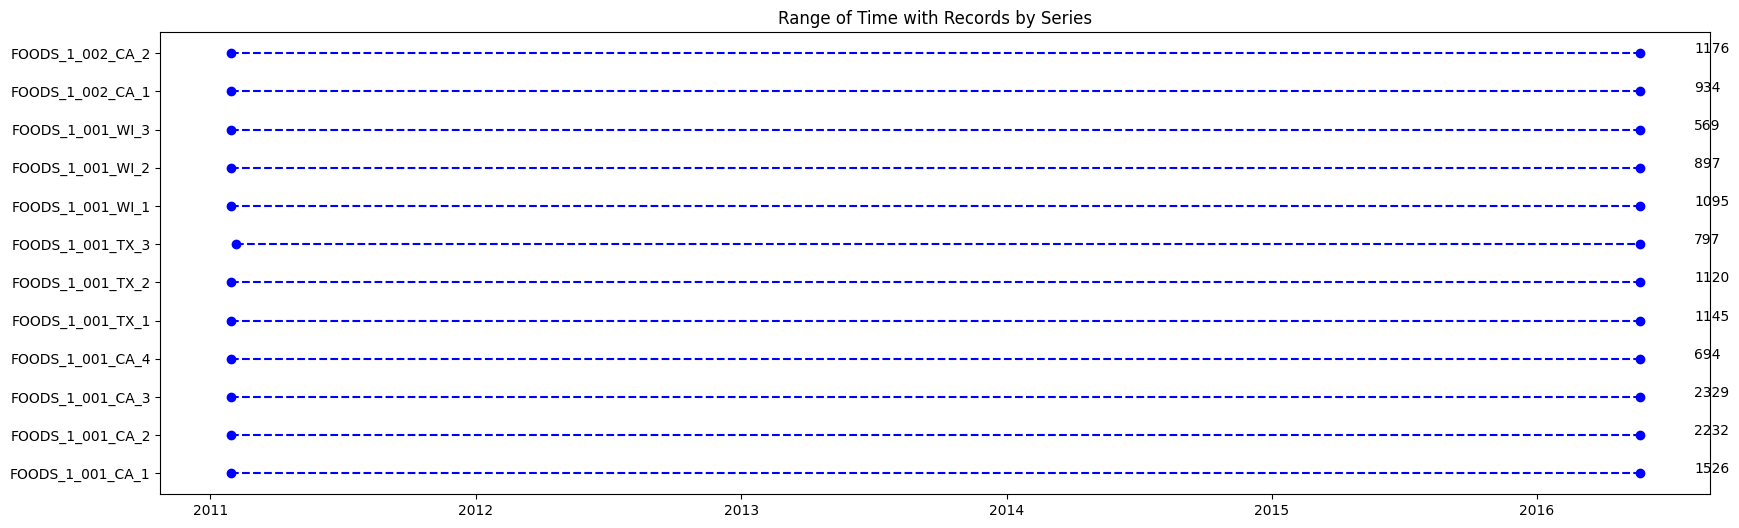

In [19]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

In [23]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq_client.query(query).to_dataframe()

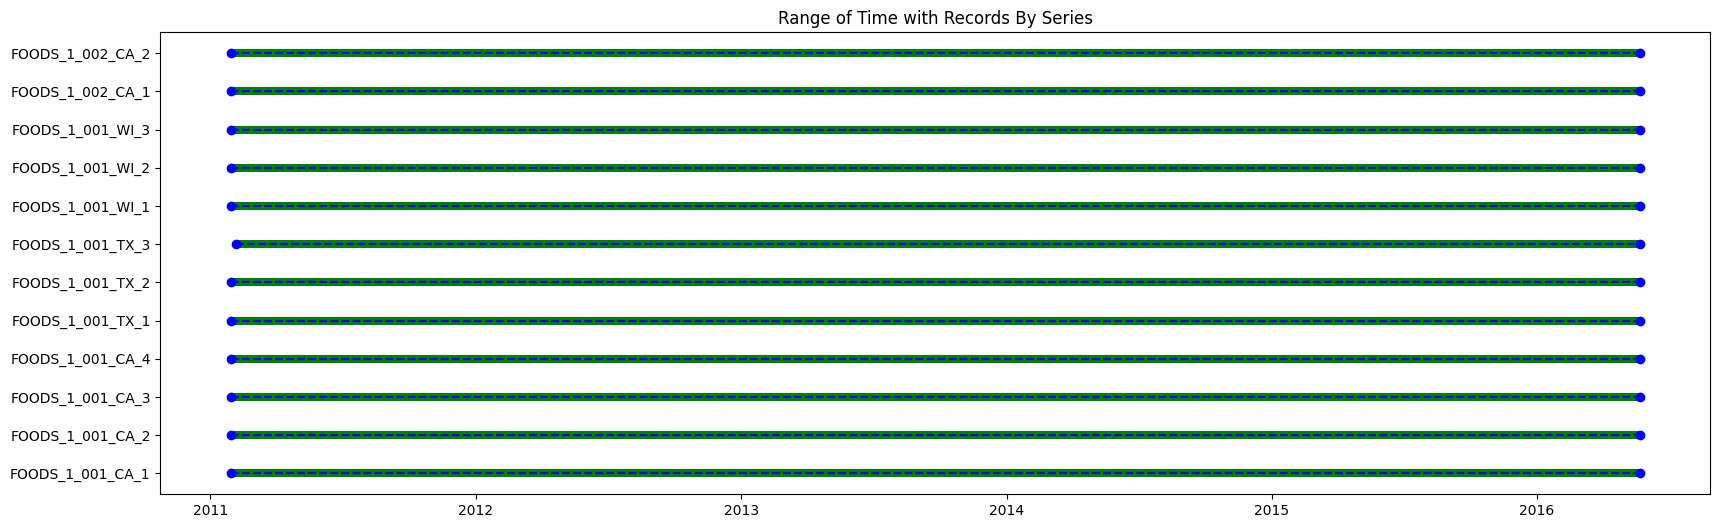

In [22]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

## Propose Train/Validation/Test Splits by Date Range

Get key dates from the series data while setting the forcast horizon:

In [27]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
forecast_val_length = 14

In [24]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2011-01-29,2016-04-25,2016-05-09,2016-05-22


Visualize each series date/time range with proposed data segments from key dates:

In [25]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

NameError: name 'overview' is not defined

<Figure size 2000x600 with 0 Axes>

## Create BigQuery Table for Forecast train dataset

In [28]:
query = f"""
    CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS splits
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

9.043

### Review Forecasting Data

In [29]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

,timeseries_id,TRAIN,VALIDATE,TEST,gross_quantity
0,FOODS_1_001_CA_1,1913,14,14,1526
1,FOODS_1_001_CA_2,1913,14,14,2232
2,FOODS_1_001_CA_3,1913,14,14,2329
3,FOODS_1_001_CA_4,1913,14,14,694
4,FOODS_1_001_TX_1,1913,14,14,1145
5,FOODS_1_001_TX_2,1913,14,14,1120
6,FOODS_1_001_TX_3,1906,14,14,797
7,FOODS_1_001_WI_1,1913,14,14,1095
8,FOODS_1_001_WI_2,1913,14,14,897
9,FOODS_1_001_WI_3,1913,14,14,569


Totals by data split:

In [30]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       46027957
VALIDATE      426860
TEST          426860
dtype: int64

Overall total:

In [31]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

46881677

Visualize days of data available for forecasting at each series:

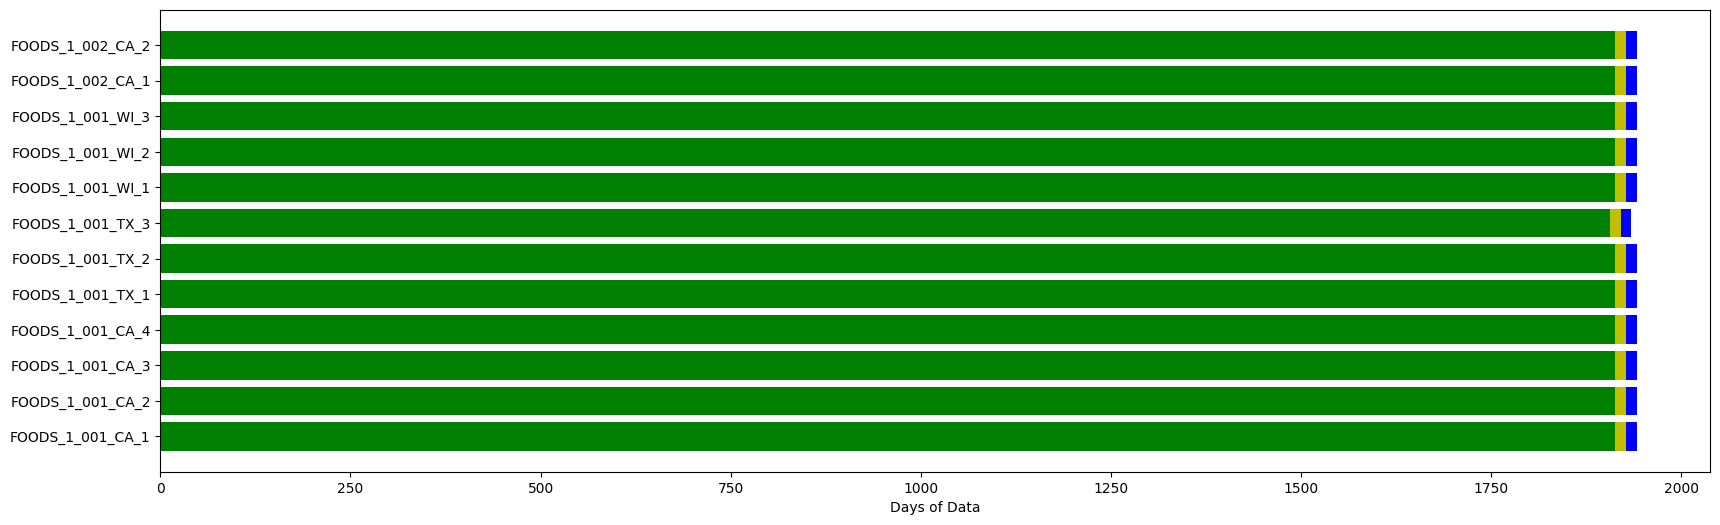

In [32]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

### Data Validation

#### Validation Check: Extract dates for splits from source

In [33]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

# print to run in BigQuery console
# print(query)

,start_date,val_start,test_start,end_date
0,2011-01-29,2016-04-25,2016-05-09,2016-05-22


#### Validation Check: Duplicate Dates in Series?

In [34]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq_client.query(query).to_dataframe()

,timeseries_id,date,records


### Time Series Review

In [35]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq_client.query(query).to_dataframe()

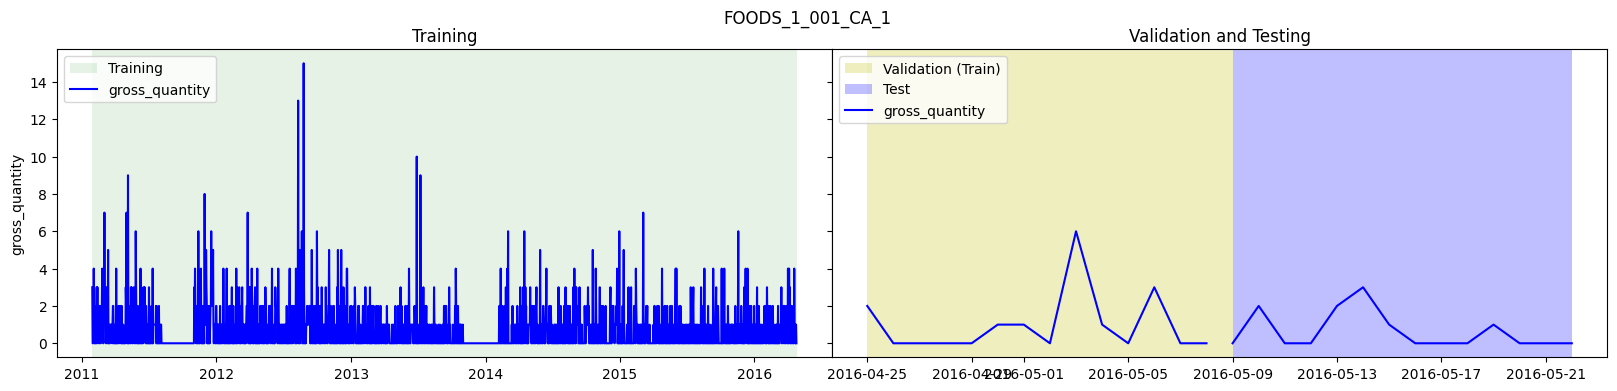

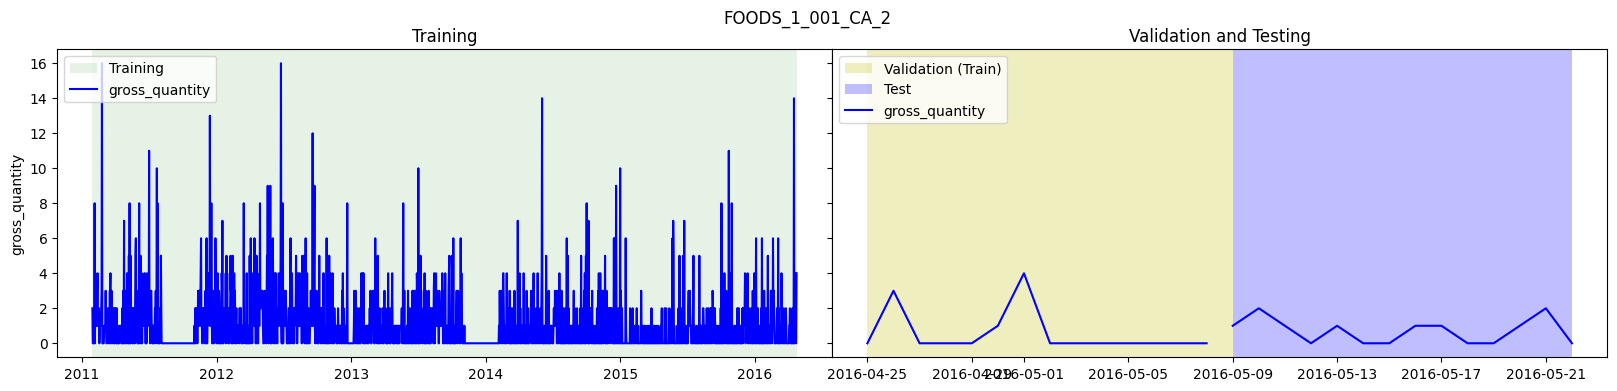

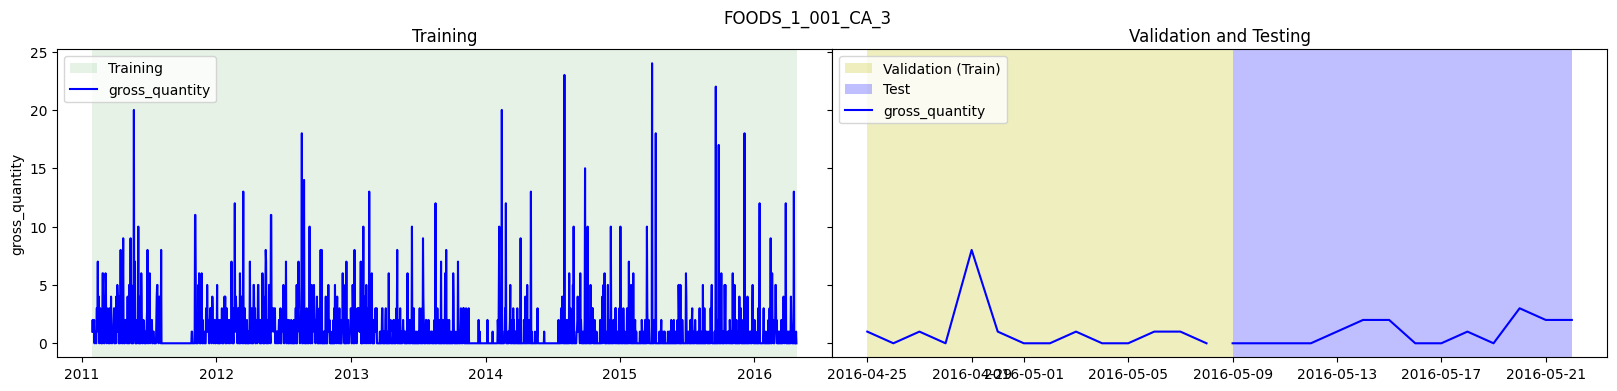

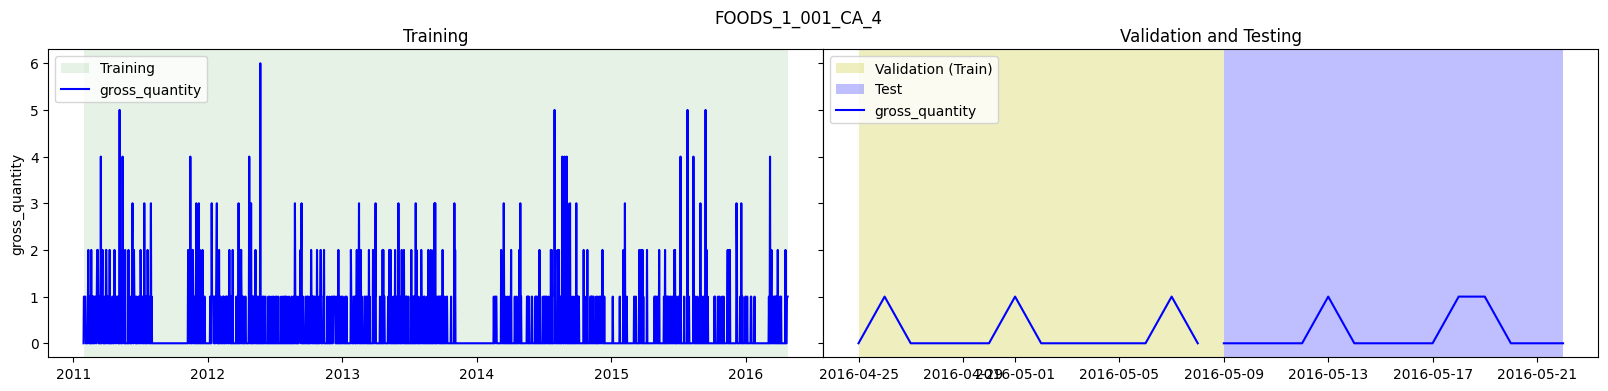

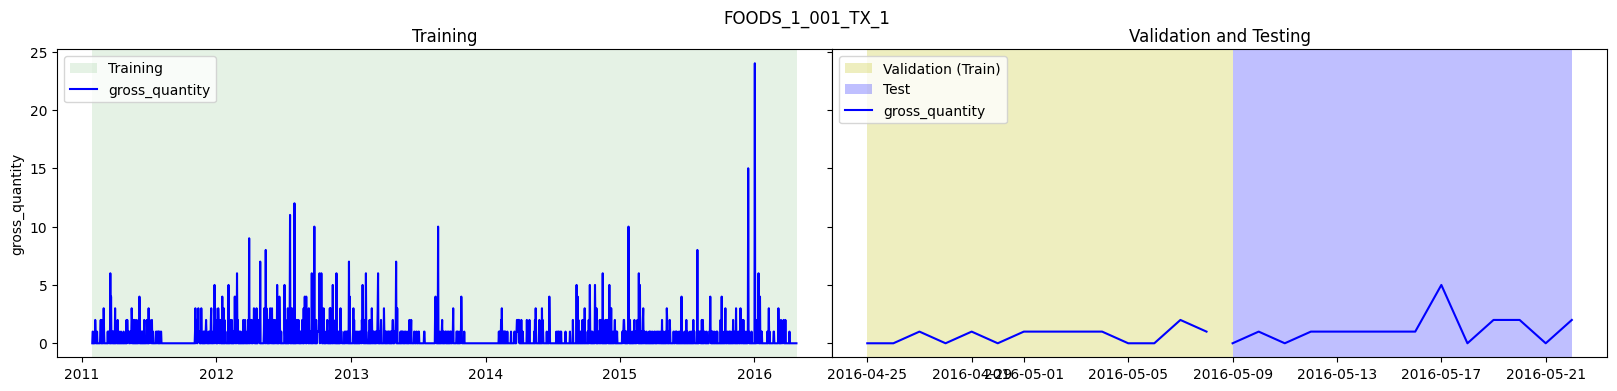

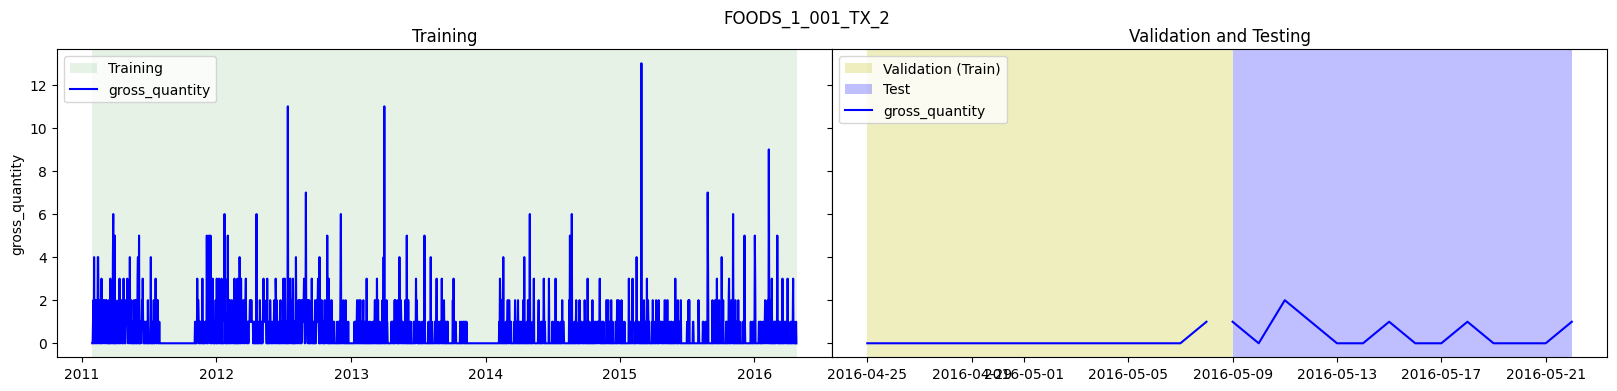

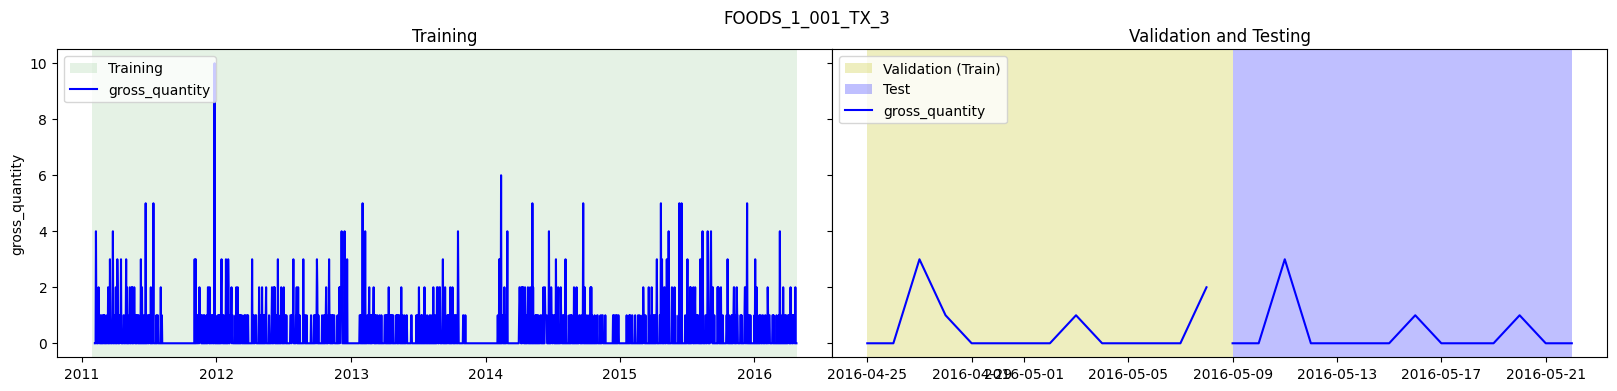

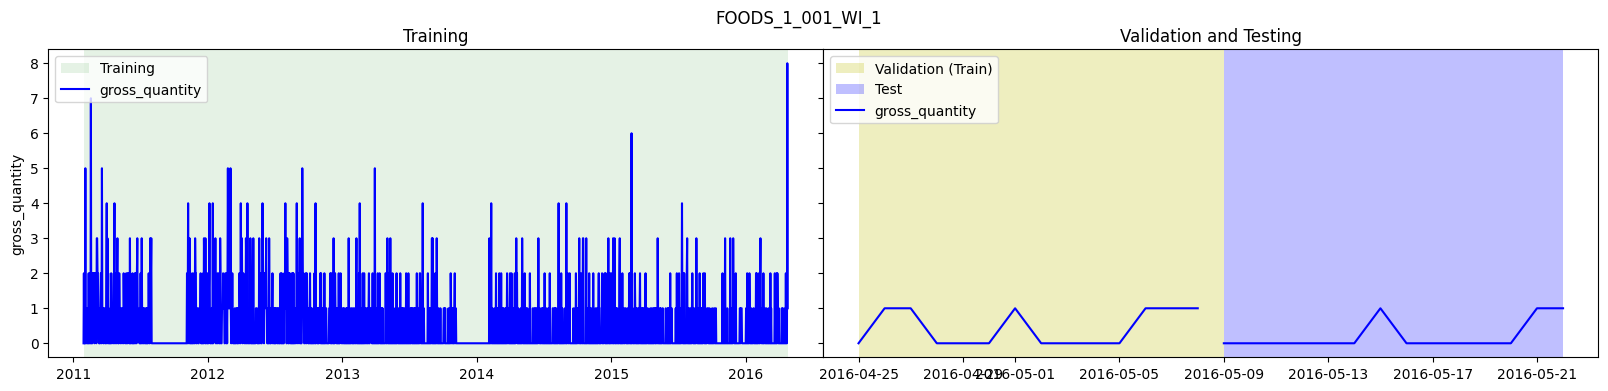

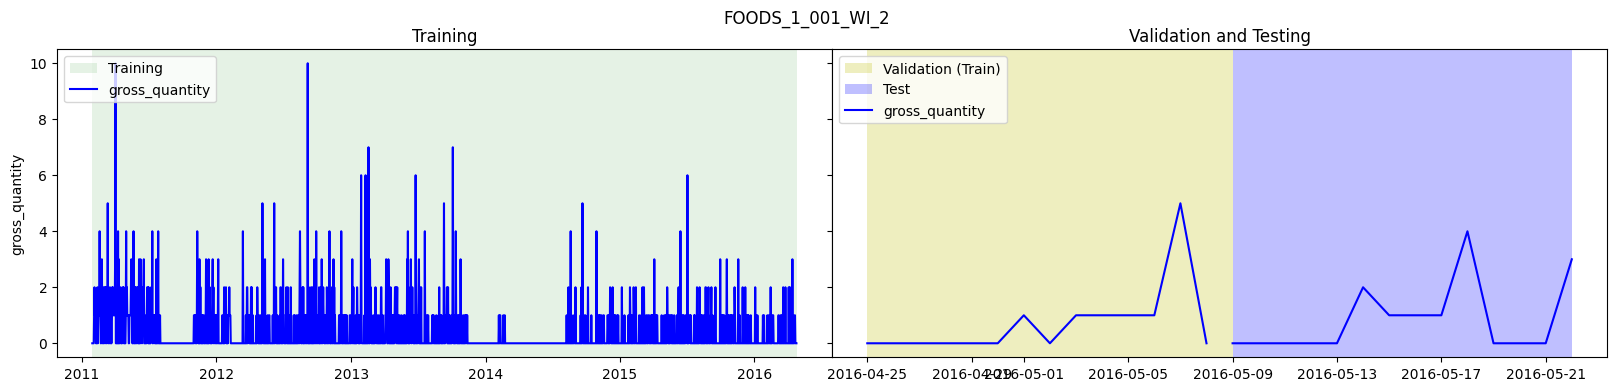

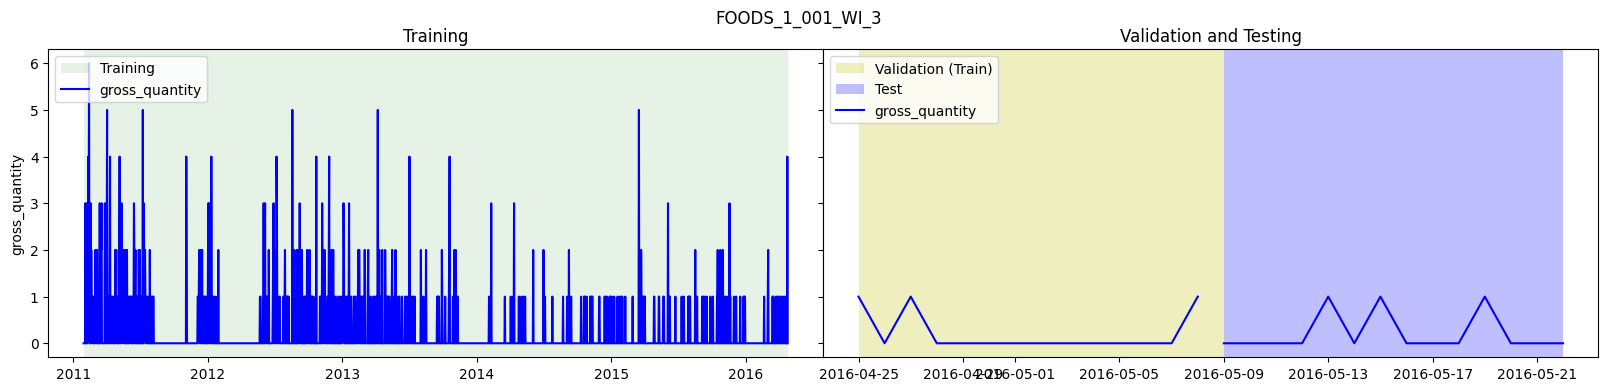

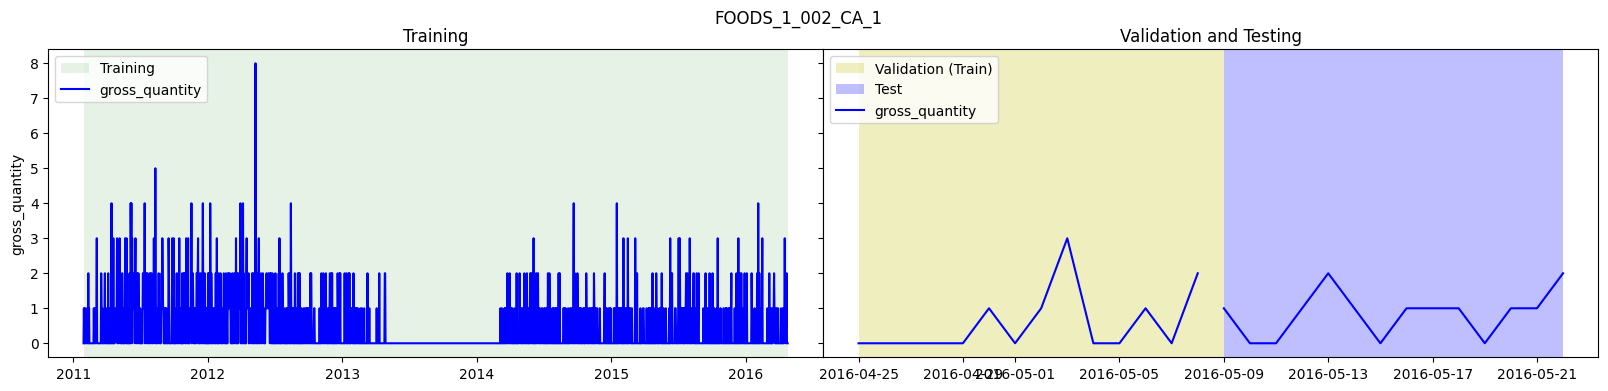

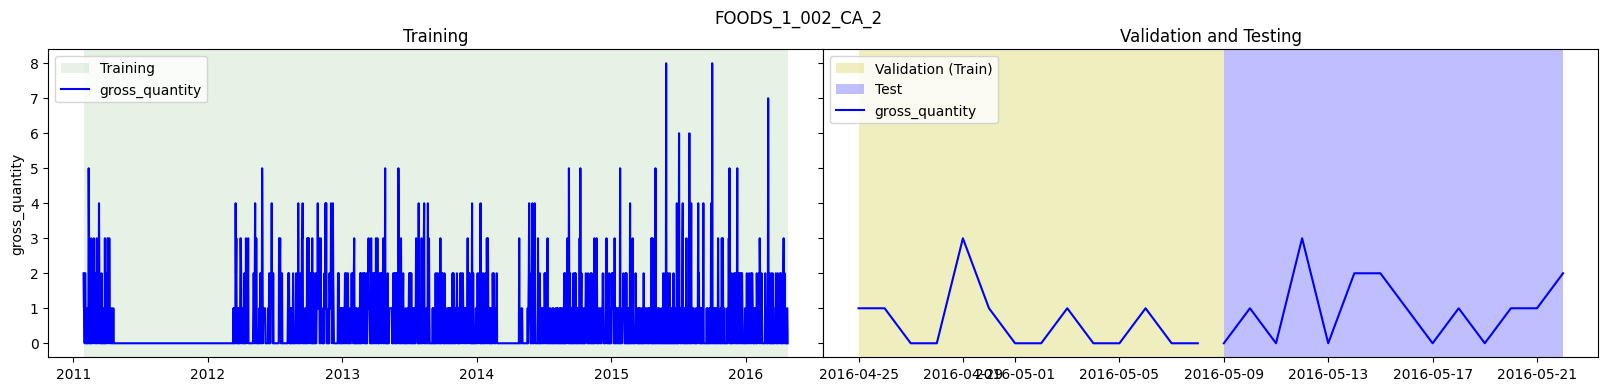

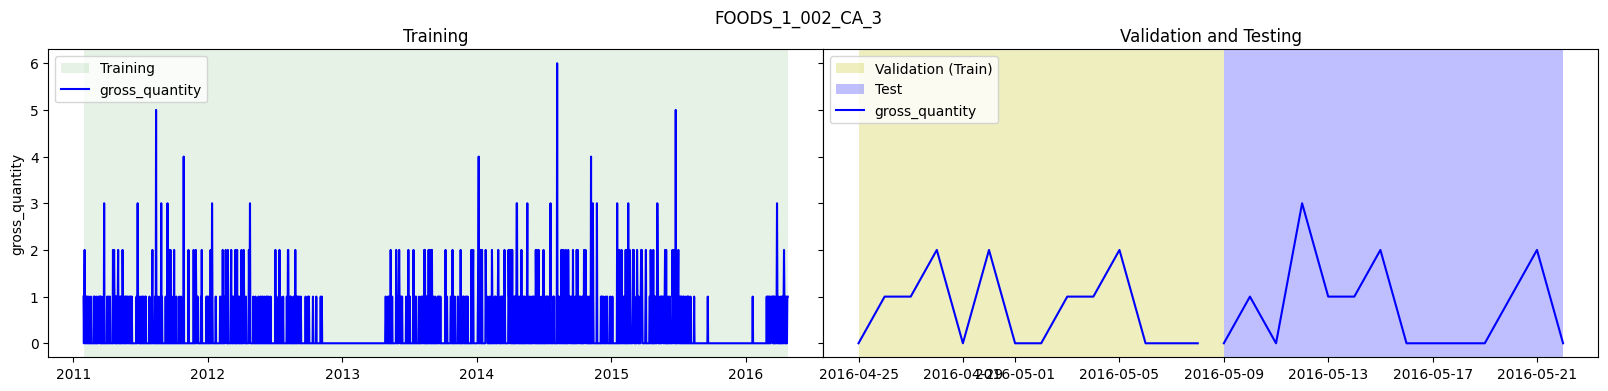

In [36]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

### Plot Time Series - Overlay Covariates

In [40]:
# series = rawSeries[SERIES_COLUMN].unique().tolist()
# for s, st in enumerate(series):
#     if s <= viz_limit:
#         # setup plot area
#         fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
#         fig.subplots_adjust(wspace=0)

#         # data
#         traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
#         valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
#         testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

#         # regions
#         axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
#         axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
#         axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

#         # lines and dots
#         axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
#         axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
#         axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

#         # labels
#         axes[0].set_ylabel(TARGET_COLUMN)
#         axes[0].set_title('Training')
#         axes[1].set_title('Validation and Testing')
#         axes[1].legend(loc = 'upper left')
#         axes[0].legend(loc = 'upper left')
#         plt.suptitle(st)

#         # overaly covariates (up to 5):
#         for c, cov in enumerate(COVARIATE_COLUMNS):
#             colors = ['g','c','m','b','r']
#             if c<5:
                
#                 twin = axes[0].twinx()
#                 twin.plot(traindf[TIME_COLUMN], traindf[cov], color = colors[c], label = f'{cov}')
                
#                 twin = axes[1].twinx()
#                 twin.set_ylabel(cov, color = colors[c])
#                 twin.tick_params(axis = 'y', labelcolor = colors[c])
#                 twin.spines.right.set_position(("axes", 1+.05*c))
#                 twin.plot(valdf[TIME_COLUMN], valdf[cov], color = colors[c], label = f'{cov}')
#                 twin.plot(testdf[TIME_COLUMN], testdf[cov], color = colors[c], label = f'{cov}')
        
#         # display result
#         plt.show()

## Create BigQuery Table for Forecast plan

In [45]:
BQ_TABLE_PLAN

'sdk_plan'

In [49]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, 
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}, 
        min({TIME_COLUMN}) as FromDate, 
        max({TIME_COLUMN}) as ToDate
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_PLAN}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq_client.query(query).to_dataframe()
overview.head(viz_limit)

# print to run in BigQuery console
# print(query)

,timeseries_id,gross_quantity,FromDate,ToDate
0,FOODS_1_001_CA_1,61,2016-01-01,2016-04-24
1,FOODS_1_001_CA_2,92,2016-01-01,2016-04-24
2,FOODS_1_001_CA_3,99,2016-01-01,2016-04-24
3,FOODS_1_001_CA_4,21,2016-01-01,2016-04-24
4,FOODS_1_001_TX_1,70,2016-01-01,2016-04-24
5,FOODS_1_001_TX_2,61,2016-01-01,2016-04-24
6,FOODS_1_001_TX_3,33,2016-01-01,2016-04-24
7,FOODS_1_001_WI_1,41,2016-01-01,2016-04-24
8,FOODS_1_001_WI_2,24,2016-01-01,2016-04-24
9,FOODS_1_001_WI_3,8,2016-01-01,2016-04-24


In [ ]:
# query = f"""
#     CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_PLAN}_bp` AS
#     SELECT *,
#        CASE
#            WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_PLAN}_source`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
#            WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_PLAN}_source`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
#            ELSE "TRAIN"
#        END AS splits
#     FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}_source`
# """
# job = bq_client.query(query)
# job.result()
# (job.ended-job.started).total_seconds()

### Review Plan table

In [51]:
# BQ_PLAN_URI = f'{PROJECT_ID}.{BQ_DATASET}.{BQ_PLAN_TABLE}'

query = f"""
    SELECT 
        {SERIES_COLUMN},
        #COUNTIF(splits='TRAIN') as TRAIN,
        #COUNTIF(splits='VALIDATE') as VALIDATE,
        #COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_PLAN}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

,timeseries_id,gross_quantity
0,FOODS_1_001_CA_1,61
1,FOODS_1_001_CA_2,92
2,FOODS_1_001_CA_3,99
3,FOODS_1_001_CA_4,21
4,FOODS_1_001_TX_1,70
5,FOODS_1_001_TX_2,61
6,FOODS_1_001_TX_3,33
7,FOODS_1_001_WI_1,41
8,FOODS_1_001_WI_2,24
9,FOODS_1_001_WI_3,8


### Data Validation

#### Validation Check: Extract dates for splits from source

#### Validation Check: Duplicate Dates in Series?

In [53]:
query = f"""
    WITH
        DAYS AS (
            SELECT 
                {SERIES_COLUMN}, 
                {TIME_COLUMN}, 
                count(*) as records
            FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_PLAN}_source`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq_client.query(query).to_dataframe()

,timeseries_id,date,records


# Create Small Datasets for devlopment

In [ ]:
## TODO